# $\Delta t$ variation

In [21]:
import numpy as np

# Now you can import from cond_expect_ols.py living in that parent folder
from conditional_expectation_methods import compute_ols_parameters, nadaraya_watson, knn_conditional_expectation_improved
from wasserstein_distances import W2_empirical
from EM import euler_maruyama_coupling

def compute_gradient_U(x, mu1=0.0, sigma1=1.0):
    # x: array-like or scalar
    return (x - mu1) / (sigma1**2)

def compute_gradient_V(y, mu2=2.0, sigma2=0.5):
    return (y - mu2) / (sigma2**2)

def sample_bivariate_normal(n, mu1, sigma1, mu2, sigma2, rho, seed=None):
    """Return arrays X, Y of length n with specified Gaussian marginals
       and correlation rho."""
    rng = np.random.default_rng(seed)

    cov = np.array([[sigma1**2,        rho*sigma1*sigma2],
                    [rho*sigma1*sigma2, sigma2**2       ]])
    mean = np.array([mu1, mu2])

    samples = rng.multivariate_normal(mean, cov, size=n)
    X, Y   = samples.T
    return X, Y


# ---------------------------------------
# 2. Parameters
# ---------------------------------------
num_samples = int(1e3)
d = 1
epsilon     = 1e-6      # noise parameter
T           = 20        # final time
k_neighbors = int(np.round(num_samples**(2/(d+4))))        # for k-NN
seed        = 42

X0, Y0 = sample_bivariate_normal(
    n=num_samples,
    mu1=0,   sigma1=1,
    mu2=2,   sigma2=0.5,
    rho=0.6,
    seed=42
)

W2_sq_emp = W2_empirical(X0, Y0) ** 2


dt_list = np.linspace(0.1, 0.001, 12)

rel_errors  = []
time_arrays = []

for dt in dt_list:
    # Determine N = round(T / Δt)
    N = int(np.round(T / dt))
    
    # -------------------------------
    # Real implementation (uncomment below in your environment):
    # -------------------------------
    err_kNN, X_kNN, Y_kNN, _, mY_kNN, mX_kNN = euler_maruyama_coupling(
        X0, Y0,
        epsilon=epsilon,
        T=T,
        N=N,
        cond_method='knn',
        h=None,
        k=k_neighbors,
        grad_U=compute_gradient_U,
        grad_V=compute_gradient_V,
        compute_W2_sq=None,
        seed=seed
    )
    
    # Compute rel_err(t) = ((err_kNN(t) – W2_sq_emp)²) / (W2_sq_emp²)
    rel_err = (err_kNN - W2_sq_emp)**2 / (W2_sq_emp**2)
    t       = np.linspace(0, T, len(err_kNN))
    rel_errors.append(rel_err)
    time_arrays.append(t)

# At this point:
# - `rel_errors[i]` is the array of relative L2 errors for dt_list[i].
# - `time_arrays[i]` is the corresponding time grid.
# You can now plot, save, or process these arrays as needed.


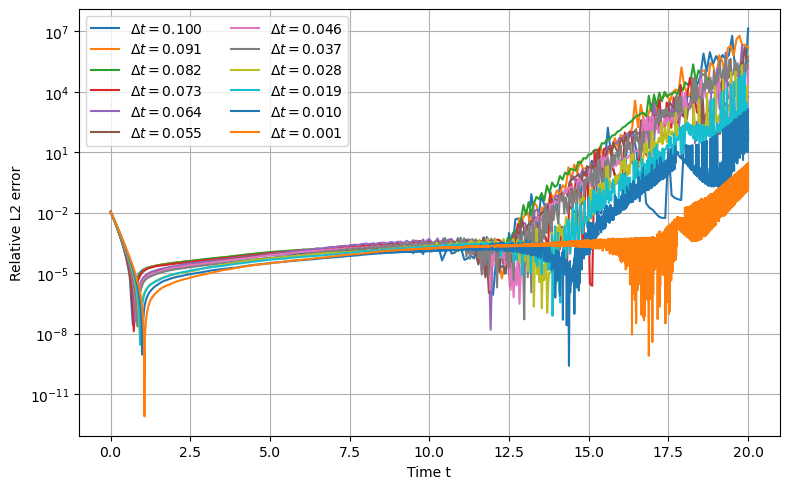

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for dt, t, rel_err in zip(dt_list, time_arrays, rel_errors):
    plt.semilogy(t, rel_err, label=rf"$\Delta t={dt:.3f}$")
plt.xlabel("Time t")
plt.ylabel("Relative L2 error")
plt.grid(True)
plt.legend(loc="upper left", ncol=2)
plt.tight_layout()
plt.savefig("knn_hyperparam_dt.png", dpi=300)
plt.show()


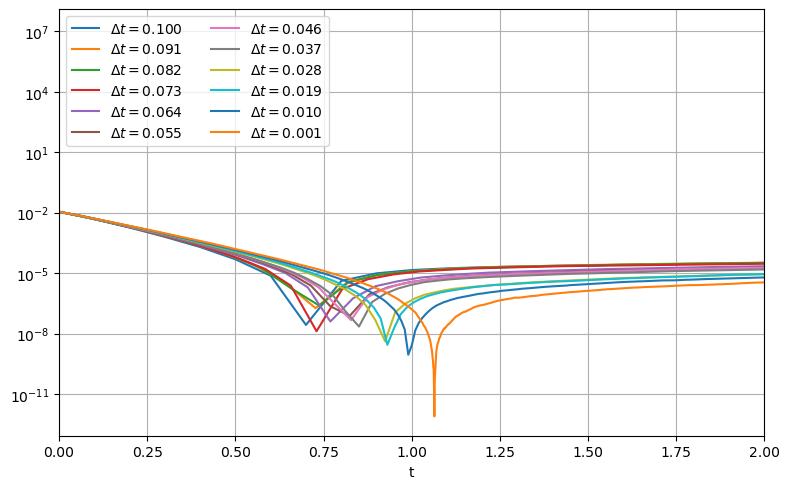

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for dt, t, rel_err in zip(dt_list, time_arrays, rel_errors):
    plt.semilogy(t, rel_err, label=rf"$\Delta t={dt:.3f}$")

plt.xlabel("t")
plt.grid(True)
plt.legend(loc="upper left", ncol=2)

# zoom in to [0, 2.5]
plt.xlim(0, 2)

plt.tight_layout()
plt.savefig("knn_hyperparam_dt_zoom.png", dpi=300)
plt.show()

# $\varepsilon$ variation

In [18]:
import numpy as np

from conditional_expectation_methods import compute_ols_parameters, nadaraya_watson, knn_conditional_expectation_improved
from wasserstein_distances import W2_empirical
from EM import euler_maruyama_coupling

def compute_gradient_U(x, mu1=0.0, sigma1=1.0):
    return (x - mu1) / (sigma1**2)

def compute_gradient_V(y, mu2=2.0, sigma2=0.5):
    return (y - mu2) / (sigma2**2)

def sample_bivariate_normal(n, mu1, sigma1, mu2, sigma2, rho, seed=None):
    rng = np.random.default_rng(seed)
    cov = np.array([[sigma1**2, rho * sigma1 * sigma2],
                    [rho * sigma1 * sigma2, sigma2**2]])
    mean = np.array([mu1, mu2])
    samples = rng.multivariate_normal(mean, cov, size=n)
    return samples[:, 0], samples[:, 1]

num_samples = int(1e3)
d = 1
T = 20
k_neighbors = int(np.round(num_samples**(2/(d+4))))
seed = 42

X0, Y0 = sample_bivariate_normal(
    n=num_samples,
    mu1=0, sigma1=1,
    mu2=2, sigma2=0.5,
    rho=0.6,
    seed=seed
)

W2_sq_emp = W2_empirical(X0, Y0)**2

# 12 values of epsilon from 0.1 down to 1e-8
eps_list = np.logspace(-1, -8, 12)

# fix dt and N
dt = 0.01
N = int(np.round(T / dt))

rel_errors = []
time_arrays = []

for epsilon in eps_list:
    err_kNN, X_kNN, Y_kNN, _, mY_kNN, mX_kNN = euler_maruyama_coupling(
        X0, Y0,
        epsilon=epsilon,
        T=T,
        N=N,
        cond_method='knn',
        h=None,
        k=k_neighbors,
        grad_U=compute_gradient_U,
        grad_V=compute_gradient_V,
        compute_W2_sq=None,
        seed=seed
    )
    rel_err = (err_kNN - W2_sq_emp)**2 / (W2_sq_emp**2)
    t = np.linspace(0, T, len(err_kNN))
    rel_errors.append(rel_err)
    time_arrays.append(t)

# rel_errors[i] and time_arrays[i] correspond to eps_list[i]


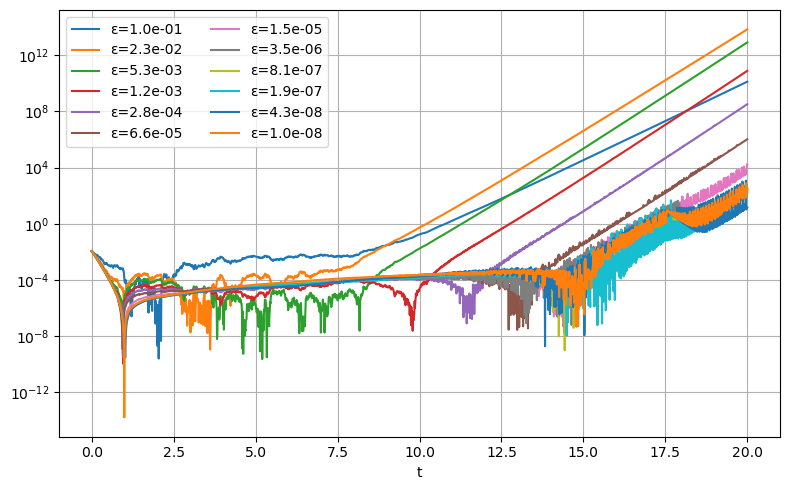

In [20]:

plt.figure(figsize=(8, 5))
for eps, t, rel_err in zip(eps_list, time_arrays, rel_errors):
    exp = int(np.round(np.log10(eps)))
    plt.semilogy(t, rel_err, label=f"ε={eps:.1e}")
plt.xlabel("t")
plt.grid("True")
plt.legend(loc="upper left", ncol=2)
plt.savefig("knn_hyperparam_epsilon.png", dpi=300)
plt.tight_layout()
plt.show()

# $N$ variation

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from conditional_expectation_methods import compute_ols_parameters, nadaraya_watson, knn_conditional_expectation_improved
from wasserstein_distances import W2_empirical
from EM import euler_maruyama_coupling

def compute_gradient_U(x, mu1=0.0, sigma1=1.0):
    return (x - mu1) / (sigma1**2)

def compute_gradient_V(y, mu2=2.0, sigma2=0.5):
    return (y - mu2) / (sigma2**2)

def sample_bivariate_normal(n, mu1, sigma1, mu2, sigma2, rho, seed=None):
    rng = np.random.default_rng(seed)
    cov = np.array([[sigma1**2, rho * sigma1 * sigma2],
                    [rho * sigma1 * sigma2, sigma2**2]])
    mean = np.array([mu1, mu2])
    samples = rng.multivariate_normal(mean, cov, size=n)
    return samples[:, 0], samples[:, 1]

eps = 1e-6
T = 20
dt = 0.01
N = int(np.round(T / dt))
t = np.linspace(0, T, N + 1)
d = 1
seed = 42

n_list = [10, 100, 1000, 10000]
rel_errors = []

for n_samples in n_list:
    X0, Y0 = sample_bivariate_normal(
        n=n_samples,
        mu1=0, sigma1=1,
        mu2=2, sigma2=0.5,
        rho=0.6,
        seed=seed
    )
    W2_sq_emp = W2_empirical(X0, Y0)**2
    k_neighbors = int(np.round(n_samples**(2/(d+4))))
    
    err_kNN, *_ = euler_maruyama_coupling(
        X0, Y0,
        epsilon=eps,
        T=T,
        N=N,
        cond_method='knn',
        h=None,
        k=k_neighbors,
        grad_U=compute_gradient_U,
        grad_V=compute_gradient_V,
        compute_W2_sq=None,
        seed=seed
    )
    rel_err = (err_kNN - W2_sq_emp)**2 / (W2_sq_emp**2)
    rel_errors.append(rel_err)



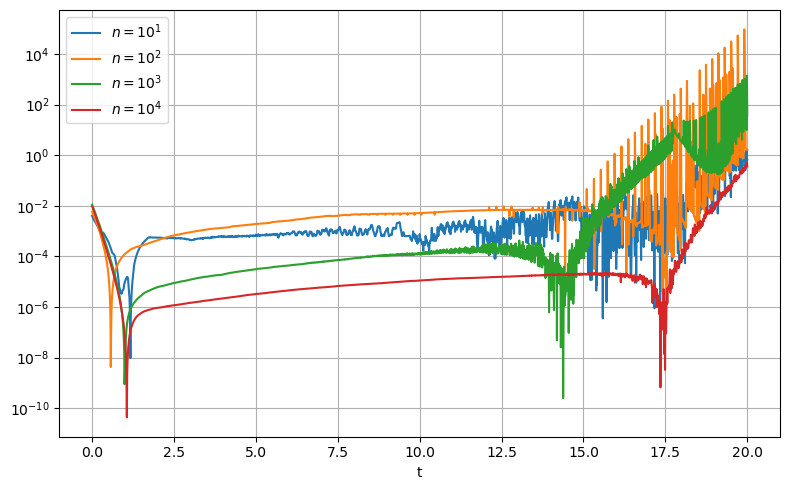

In [17]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for n_samples, rel_err in zip(n_list, rel_errors):
    exp = int(np.round(np.log10(n_samples)))
    plt.semilogy(t, rel_err, label=rf"$n=10^{exp}$")
plt.xlabel("t")
plt.grid("True")
plt.legend(loc="upper left")
plt.savefig("knn_hyperparam_num_samples.png", dpi=300)
plt.tight_layout()
plt.show()


# Animation & Snapshots

In [3]:

import numpy as np
import matplotlib.pyplot as plt

from conditional_expectation_methods import compute_ols_parameters, nadaraya_watson, knn_conditional_expectation_improved
from wasserstein_distances import W2_empirical
from EM import euler_maruyama_coupling

def compute_gradient_U(x, mu1=0.0, sigma1=1.0):
    return (x - mu1) / (sigma1**2)

def compute_gradient_V(y, mu2=2.0, sigma2=0.5):
    return (y - mu2) / (sigma2**2)

def sample_bivariate_normal(n, mu1, sigma1, mu2, sigma2, rho, seed=None):
    rng = np.random.default_rng(seed)
    cov = np.array([[sigma1**2, rho * sigma1 * sigma2],
                    [rho * sigma1 * sigma2, sigma2**2]])
    mean = np.array([mu1, mu2])
    samples = rng.multivariate_normal(mean, cov, size=n)
    return samples[:, 0], samples[:, 1]

# 1. Parameters
num_samples = 1_000
epsilon     = 1e-8
T           = 20
N           = 1000
k_neighbors = 15
h           = 0.01
dt          = T / N
sqrt_2eps_dt = np.sqrt(2 * epsilon * dt)
seed        = 42
X0, Y0 = sample_bivariate_normal(
    n=num_samples,
    mu1=0, sigma1=1,
    mu2=2, sigma2=0.5,
    rho=0.6,
    seed=42
)
# 2. Initial samples
rng = np.random.RandomState(seed)
W2_sq = W2_empirical(X0, Y0)**2
print(W2_sq) # empirical W2^2 from initial samples


# 7. k-NN
errs_knn, Xt_knn, Yt_knn, _, mY_kNN, mX_kNN = euler_maruyama_coupling(
    X0, Y0,
    epsilon=epsilon,
    T=T,
    N=N,
    cond_method='knn',
    h=None,
    k=k_neighbors,
    grad_U=compute_gradient_U,
    grad_V=compute_gradient_V,
    compute_W2_sq=None,
    seed=seed
)

4.007905646967689


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


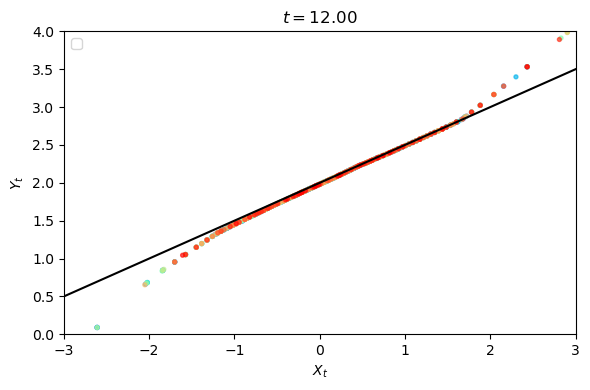

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


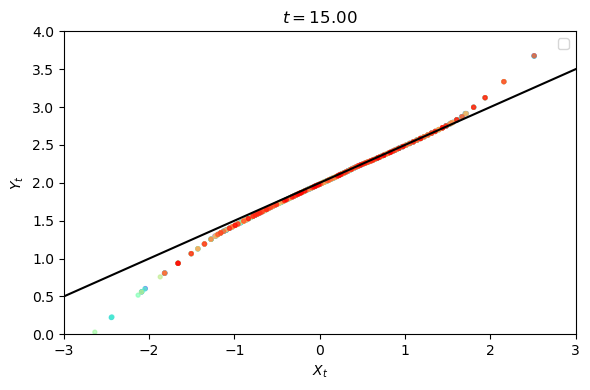

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


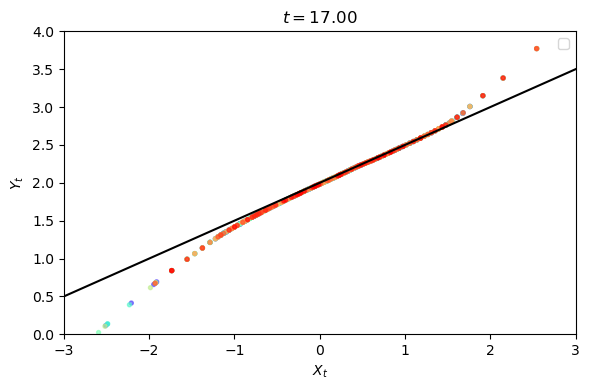

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


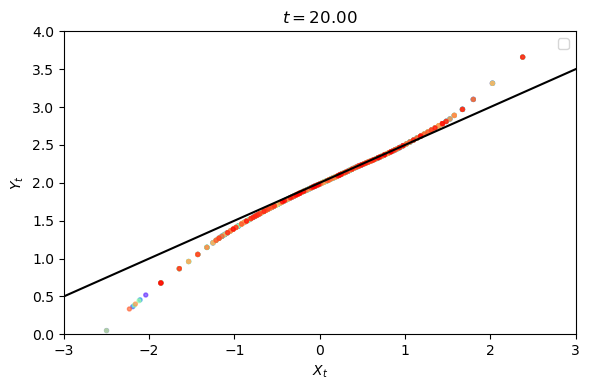

: 

In [ ]:
import numpy as np
import matplotlib.animation as animation
import os
import sys

# make sure 'animations' is on the import path
sys.path.insert(0, os.path.abspath('animations'))

from utils import animate_coupling, save_scatter_snapshot
# 1) Gaussian parameters
mu1, sigma1 = 0.0, 1.0
mu2, sigma2 = 2.0, 0.5

# 2) Define the analytic OT map for Gaussians
T_map = lambda x: mu2 + (sigma2/sigma1) * (x - mu1)

# 3) Time grid (unchanged)
t = np.linspace(0, T, N+1)
# # 4) Animate the coupling (example for the OLS run)
# ani = animate_coupling(
#     Xt_knn,
#     Yt_knn,
#     errs_knn,
#     t,
#     T_map,
#     filepath='coupling_with_OT_map_gauss_kNN.mp4',
#     fps=15,
#     interval=60,
#     figsize=(11, 4),
#     cmap='rainbow'
# )

# 5) Save snapshots at specific times
snapshot_times = [12, 15, 17, 20]
for tau in snapshot_times:
    save_scatter_snapshot(
        time_point=tau,
        t=t,
        X_traj=Xt_knn,
        Y_traj=Yt_knn,
        T_map=T_map,
        filename=f'coupling_with_OT_map_gauss_knn_snapshot_t{tau:.2f}.png'
    )
